Max: 1.0117142923519982 Mean: 1.011677556197488
Max: 1.0866679466643074 Mean: 1.081746503219606
Max: 1.3469193254900258 Mean: 1.3033791768095508
Max: 5.196496761232844 Mean: 3.565709947716654


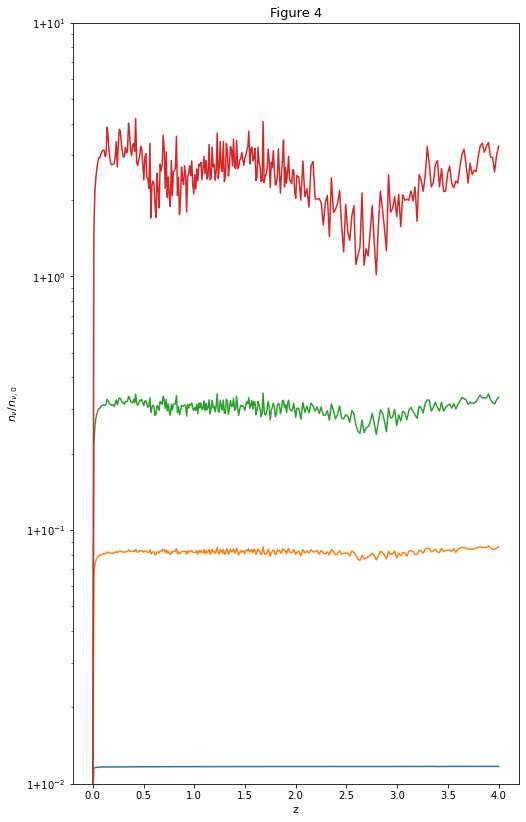

In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

def n_nu_of_redshift(m_sim_eV, m_nu_eV):

    # load initial and final velocity
    Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)  # Nr. of neutrinos
    sim = np.array([np.load(f'neutrino_vectors/nu_{Nr+1}.npy') for Nr in Ns])
    u_all = sim[:,:,3:6]  # (10000, 100, 3) shape, ndim = 3
    
    # Convert to momenta; (10000, 100) shape, ndim = 2
    p, _ = fct.u_to_p_eV(u_all, m_sim_eV, m_nu_eV)

    zeds = CC.ZEDS

    n_nus = np.zeros(len(zeds))
    for i, z in enumerate(zeds):

        # Calculate number density.
        n_nus[i] = fct.number_density(p[:,0], p[:,i], z).value

    np.save(f'neutrino_data/number_densities_at_z_{m_nu_eV.value}eV.npy', n_nus)


z_array = CC.ZEDS

fig, ax = plt.subplots(1,1, figsize=(8,14))

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m in enumerate(masses):
    n_nu_of_redshift(CC.NU_MASS, m)

    n = np.load(f'neutrino_data/number_densities_at_z_{m.value}eV.npy')/CC.N0
    print('Max:', np.max(n),'Mean:', np.mean(n))

    ax.semilogy(CC.ZEDS, n-1)

ax.set_title('Figure 4')
ax.set_xlabel('z')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
ax.set_ylim(1e-2, 1e1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))
plt.savefig('check_plots/figure_4.pdf')
plt.show()

## Momentum behaviour

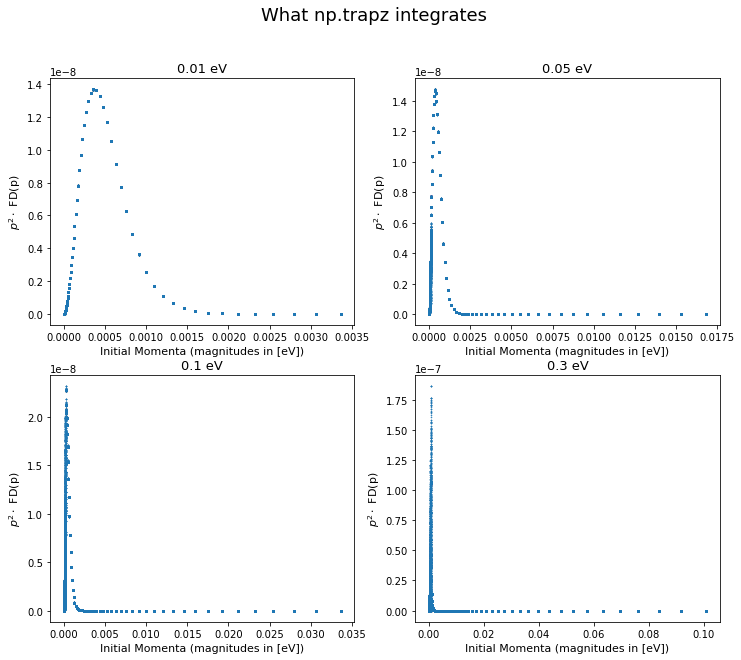

In [2]:
def momentum_shape(m_sim_eV, m_nu_eV):

    # load initial and final velocity
    Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)  # Nr. of neutrinos
    u0 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[0][3:6] for Nr in Ns]
    u1 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[-1][3:6] for Nr in Ns]
    u0, u1 = np.array(u0), np.array(u1)

    # Get momenta.
    p0, _ = fct.u_to_p_eV(u0, m_sim_eV, m_nu_eV)
    p1, _ = fct.u_to_p_eV(u1, m_sim_eV, m_nu_eV)

    #NOTE: trapz integral method needs sorted (ascending) arrays
    order = p0.argsort()
    p0_sort, p1_sort = p0[order], p1[order]

    # precomputed factors
    FDvals = fct.Fermi_Dirac(p1_sort, CC.Z_STOP)  #! needs p in [eV]

    return p0_sort.value, FDvals


fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle(
    'What np.trapz integrates', fontsize=18)

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m in enumerate(masses):
    p0_sort, FDvals = momentum_shape(CC.NU_MASS, m)
    y = p0_sort**2. * FDvals

    i = 0
    if j in (2,3):
        i = 1
        j -= 2

    axs[i,j].scatter(p0_sort, y, s=0.3)
    axs[i,j].set_title(f'{m.value} eV')
    axs[i,j].set_xlabel('Initial Momenta (magnitudes in [eV])')
    axs[i,j].set_ylabel(r'$p^2 \cdot$ FD(p)')

plt.savefig('check_plots/figure_4_momenta.pdf')
plt.show()